In [1]:
# pip install torch torchvision
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.utils as vutils
import torch.nn as nn
from torch.optim import lr_scheduler
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from loss_functions import CombinedLoss
from discriminator_model import DiscriminatorModel
from upscaling_model import UpscalingModel
from data_sets_loaders import get_train_val_test_dataloaders
import os

%matplotlib inline

In [2]:
def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    plt.imshow(np.transpose(vutils.make_grid(x[:4].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()


def train_prototype(upscaling_model, discriminator_model, train_dl, val_dl, num_epochs=500):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    upscaling_model = upscaling_model.to(device)
    discriminator_model = discriminator_model.to(device)
    discriminator_params = torch.cat([x.view(-1) for x in discriminator_model.parameters()])

    upscaling_model.to(device)
    discriminator_model.to(device)
    upscaling_model.train()
    discriminator_model.train()

    torch.manual_seed(42)
    criterion = CombinedLoss(0.0, 1.0, 2.0, 0.0, 1.0, device=device)
    lr, min_lr = 0.001, 0.00001
    optimizer_upscale = torch.optim.Adam(upscaling_model.parameters(), lr=lr) 
    optimizer_discriminator = torch.optim.Adam(discriminator_model.parameters(), lr=lr) 
    scheduler_upscale = lr_scheduler.ReduceLROnPlateau(
        optimizer_upscale, mode='min', min_lr=0.00001)
    scheduler_discriminator = lr_scheduler.ReduceLROnPlateau(
        optimizer_discriminator, mode='min', min_lr=0.00001)

    iters, train_losses, val_losses, discrim_train_losses, discrim_val_losses = [], [], [], [], []
    n = 0
    for epoch in range(num_epochs):

        if epoch == 2:
            criterion = CombinedLoss(0.5, 1.0, 2.0, 0.0, 1.0, device=device)
            optimizer_upscale = torch.optim.Adam(upscaling_model.parameters(), lr=lr)
            optimizer_discriminator = torch.optim.Adam(discriminator_model.parameters(), lr=lr) 

        train_count    = 0
        val_count      = 0
        train_loss_sum = 0.0
        val_loss_sum   = 0.0
        discrim_train_loss_sum = 0.0
        discrim_val_loss_sum = 0.0

        num_batches = len(train_dl)
        for batch_i, (inputs_lr, targets_hr) in enumerate(train_dl):

            inputs_lr = inputs_lr.to(device)
            targets_hr = targets_hr.to(device)

            real_labels = torch.ones(inputs_lr.shape[0], 1).to(device)
            generated_labels = torch.zeros(inputs_lr.shape[0], 1).to(device)

            # Update Discriminator
            real_outputs = discriminator_model(targets_hr)
            discriminator_loss_real = criterion(None, real_labels, real_outputs, is_discriminator=True)

            generated_hr = upscaling_model(inputs_lr)
            generated_outputs = discriminator_model(generated_hr.detach())
            discriminator_loss_generated = criterion(None, generated_labels, generated_outputs, is_discriminator=True)

            discriminator_reg_l2 = 1.0 * torch.mean((discriminator_params)**2)
            discriminator_reg_l1 = 1.0 * torch.mean(torch.abs(discriminator_params))
            discriminator_reg = discriminator_reg_l2 + discriminator_reg_l1
            discriminator_loss = discriminator_loss_real + discriminator_loss_generated + discriminator_reg

            optimizer_discriminator.zero_grad()
            discriminator_loss.backward()
            optimizer_discriminator.step()

            # Update Generator
            generated_outputs = discriminator_model(targets_hr)
            generator_loss = criterion(generated_hr, targets_hr, generated_outputs)

            optimizer_upscale.zero_grad()
            generator_loss.backward()
            optimizer_upscale.step()

            train_loss_sum += generator_loss.item()
            discrim_train_loss_sum += discriminator_loss.item()
            train_count += 1

            if (batch_i+1) % 20 == 0:
                print(f"Batch {batch_i+1}/{num_batches}, generator loss {generator_loss.item()}, discriminator loss {discriminator_loss.item()}")

        #For Validation Set 
        with torch.no_grad():
            for inputs_lr_val, targets_hr_val in val_dl: 
                inputs_lr_val = inputs_lr_val.to(device)
                targets_hr_val = targets_hr_val.to(device)

                real_labels = torch.ones(inputs_lr_val.shape[0], 1).to(device)
                generated_labels = torch.zeros(inputs_lr_val.shape[0], 1).to(device)

                real_outputs = discriminator_model(targets_hr_val)
                discriminator_loss_real = criterion(None, real_labels, real_outputs, is_discriminator=True)

                generated_hr_val = upscaling_model(inputs_lr_val)
                generated_outputs = discriminator_model(targets_hr_val)
                generator_loss = criterion(generated_hr_val, targets_hr_val, generated_outputs)

                discriminator_loss_generated = criterion(None, generated_labels, generated_outputs, is_discriminator=True)

                discriminator_reg_l2 = 1.0 * torch.mean((discriminator_params)**2)
                discriminator_reg_l1 = 1.0 * torch.mean(torch.abs(discriminator_params))
                discriminator_reg = discriminator_reg_l2 + discriminator_reg_l1
                discriminator_loss = discriminator_loss_real + discriminator_loss_generated + discriminator_reg

                val_loss_sum += generator_loss.item()
                discrim_val_loss_sum += discriminator_loss.item()
                val_count += 1

        iters.append(n+1)

        t_loss = train_loss_sum/train_count
        v_loss = val_loss_sum/val_count
        d_t_loss = discrim_train_loss_sum/train_count
        d_v_loss = discrim_val_loss_sum/val_count
        train_losses.append(t_loss)
        val_losses.append(v_loss)
        discrim_train_losses.append(d_t_loss)
        discrim_val_losses.append(d_v_loss)
        if epoch >= 2:
            scheduler_upscale.step(v_loss)
            scheduler_discriminator.step(d_v_loss)
            if scheduler_upscale.get_last_lr()[0] <= scheduler_upscale.min_lrs[0]:
                break

        n += 1
        print("#"+str(n)+": training loss value = "+str(t_loss)+" validation loss value = "+str(v_loss))
        if epoch >= 2:
            print("upscale lr: "+str(scheduler_upscale.get_last_lr()[0])+",",
                "discriminator lr: "+str(scheduler_discriminator.get_last_lr()[0]))
        if (epoch+1) % 4 == 0:
            plot_imgs(inputs_lr_val)
            plot_imgs(generated_hr_val)
            plot_imgs(targets_hr_val)
        print()

        os.makedirs("final_models", exist_ok=True)
        model_upscale_path = f"final_models/model_{epoch+1}_g.pth"
        model_discrim_path = f"final_models/model_{epoch+1}_d.pth"
        torch.save(upscaling_model, model_upscale_path)
        torch.save(discriminator_model, model_discrim_path)

    return(iters, train_losses, val_losses, discrim_train_losses, discrim_val_losses)


Batch 20/80, generator loss 9.658330917358398, discriminator loss 1.195095181465149
Batch 40/80, generator loss 8.1610689163208, discriminator loss 1.2071397304534912
Batch 60/80, generator loss 7.0943145751953125, discriminator loss 1.216198205947876
Batch 80/80, generator loss 5.231873512268066, discriminator loss 1.3199034929275513
#1: training loss value = 7.884775131940842 validation loss value = 5.432094347476959

Batch 20/80, generator loss 5.093767166137695, discriminator loss 1.4023517370224
Batch 40/80, generator loss 4.908140182495117, discriminator loss 1.3902312517166138
Batch 60/80, generator loss 4.746840000152588, discriminator loss 1.4153273105621338
Batch 80/80, generator loss 4.930342674255371, discriminator loss 1.4221705198287964
#2: training loss value = 5.111202004551887 validation loss value = 4.324031925201416

Batch 20/80, generator loss 4.493238925933838, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 4.66914176940918, discriminator loss 1.

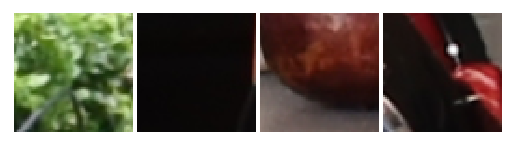

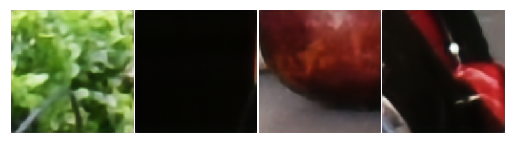

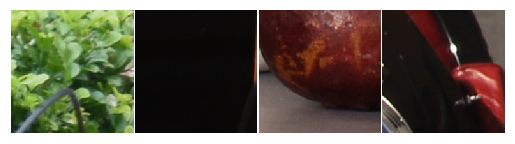


Batch 20/80, generator loss 3.804996967315674, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 3.46594500541687, discriminator loss 1.4023818969726562
Batch 60/80, generator loss 3.4759979248046875, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 5.190095901489258, discriminator loss 1.4023796319961548
#5: training loss value = 4.370751652121544 validation loss value = 3.9078330278396605
upscale lr: 0.001, discriminator lr: 0.001

Batch 20/80, generator loss 2.922226667404175, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 3.4802398681640625, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 5.231371879577637, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 2.938579797744751, discriminator loss 1.4023796319961548
#6: training loss value = 4.276659199595452 validation loss value = 3.930271828174591
upscale lr: 0.001, discriminator lr: 0.001

Batch 20/80, generator loss 5.291927814483643, discrimina

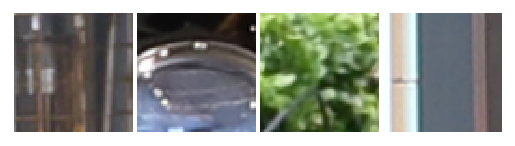

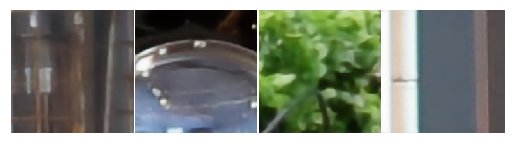

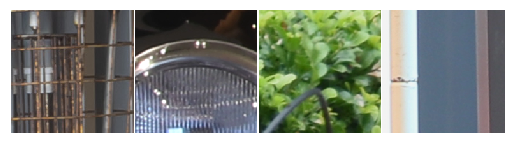


Batch 20/80, generator loss 4.168536186218262, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 3.108097553253174, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 4.3701934814453125, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 3.6297760009765625, discriminator loss 1.4023796319961548
#9: training loss value = 4.159785687923431 validation loss value = 3.860913574695587
upscale lr: 0.001, discriminator lr: 0.001

Batch 20/80, generator loss 3.123185634613037, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 4.308960914611816, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 3.8765907287597656, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 4.590962886810303, discriminator loss 1.4023796319961548
#10: training loss value = 4.136015406250953 validation loss value = 3.8321375370025637
upscale lr: 0.001, discriminator lr: 0.001

Batch 20/80, generator loss 5.327062606811523, discrim

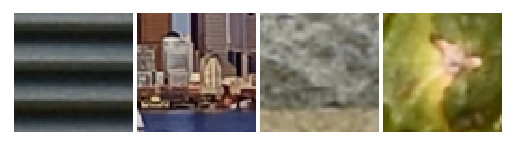

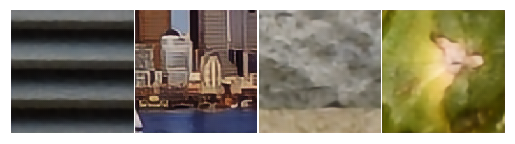

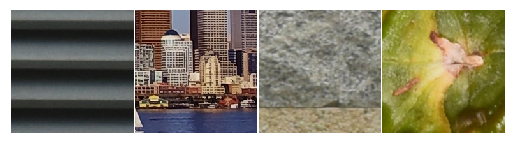


Batch 20/80, generator loss 3.699010133743286, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 5.080820083618164, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 3.358168601989746, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 4.848621368408203, discriminator loss 1.4023796319961548
#13: training loss value = 4.07660059928894 validation loss value = 3.741125762462616
upscale lr: 0.001, discriminator lr: 0.001

Batch 20/80, generator loss 4.797398567199707, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 4.6000800132751465, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 3.82844614982605, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 2.968310594558716, discriminator loss 1.4023796319961548
#14: training loss value = 4.064403221011162 validation loss value = 3.7669804215431215
upscale lr: 0.001, discriminator lr: 0.001

Batch 20/80, generator loss 5.297752857208252, discrimina

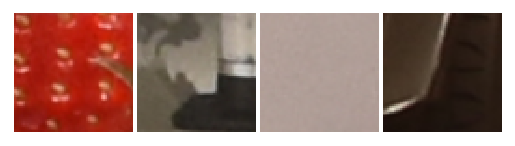

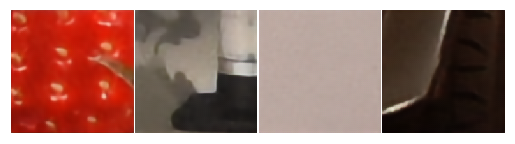

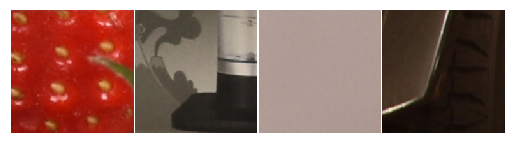


Batch 20/80, generator loss 4.534202575683594, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 3.855419158935547, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 4.768524169921875, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 3.550612449645996, discriminator loss 1.4023796319961548
#17: training loss value = 4.004345118999481 validation loss value = 3.741804099082947
upscale lr: 0.001, discriminator lr: 0.0001

Batch 20/80, generator loss 4.641974925994873, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 3.31122088432312, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 3.5491092205047607, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 3.9865806102752686, discriminator loss 1.4023796319961548
#18: training loss value = 3.9989867717027665 validation loss value = 3.7162342071533203
upscale lr: 0.001, discriminator lr: 0.0001

Batch 20/80, generator loss 4.718251705169678, discr

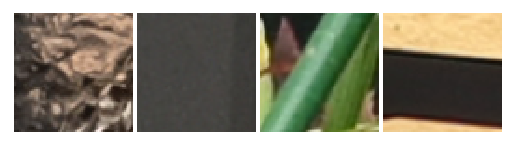

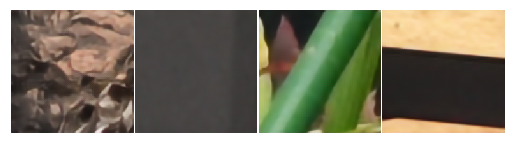

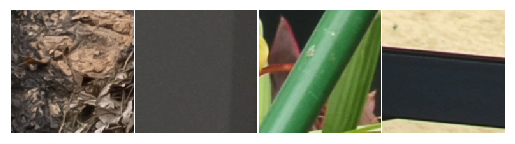


Batch 20/80, generator loss 4.867105007171631, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 4.429368495941162, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 3.6334965229034424, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 3.71567964553833, discriminator loss 1.4023796319961548
#21: training loss value = 3.941079652309418 validation loss value = 3.7387980580329896
upscale lr: 0.001, discriminator lr: 0.0001

Batch 20/80, generator loss 5.201067924499512, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 3.1020774841308594, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 2.9929163455963135, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 3.896552801132202, discriminator loss 1.4023796319961548
#22: training loss value = 3.933846613764763 validation loss value = 3.7173234462738036
upscale lr: 0.001, discriminator lr: 0.0001

Batch 20/80, generator loss 3.113811492919922, disc

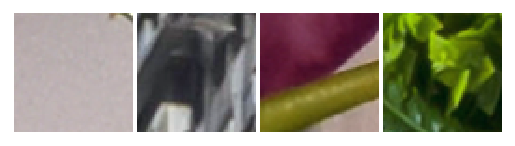

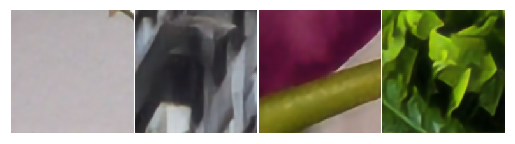

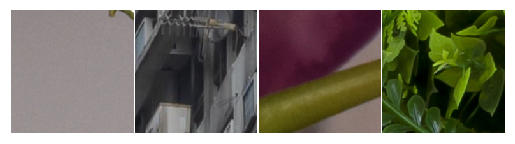


Batch 20/80, generator loss 3.830646514892578, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 4.520776748657227, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 3.698871612548828, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 2.9258179664611816, discriminator loss 1.4023796319961548
#25: training loss value = 3.900348776578903 validation loss value = 3.6849550724029543
upscale lr: 0.001, discriminator lr: 0.0001

Batch 20/80, generator loss 3.3718080520629883, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 3.7314844131469727, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 3.3451809883117676, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 4.325865745544434, discriminator loss 1.4023796319961548
#26: training loss value = 3.8973471879959107 validation loss value = 3.689461886882782
upscale lr: 0.001, discriminator lr: 1e-05

Batch 20/80, generator loss 3.5686614513397217, di

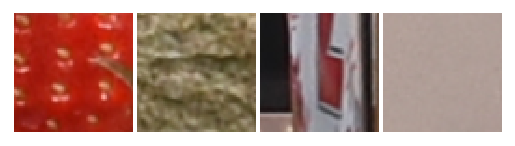

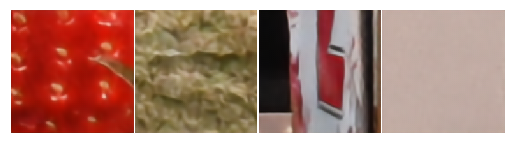

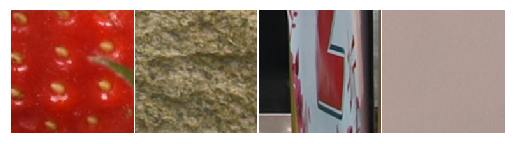


Batch 20/80, generator loss 3.2315175533294678, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 2.9440200328826904, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 3.357858419418335, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 5.827581405639648, discriminator loss 1.4023796319961548
#29: training loss value = 3.853681004047394 validation loss value = 3.675950050354004
upscale lr: 0.001, discriminator lr: 1e-05

Batch 20/80, generator loss 4.0583176612854, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 3.290794610977173, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 2.612778425216675, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 5.237780570983887, discriminator loss 1.4023796319961548
#30: training loss value = 3.8530809968709945 validation loss value = 3.6857936501502992
upscale lr: 0.001, discriminator lr: 1e-05

Batch 20/80, generator loss 3.9876866340637207, discrim

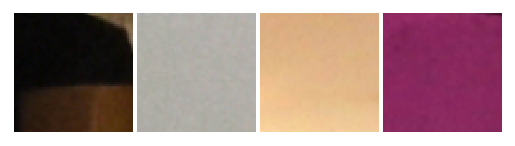

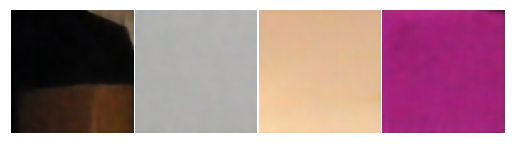

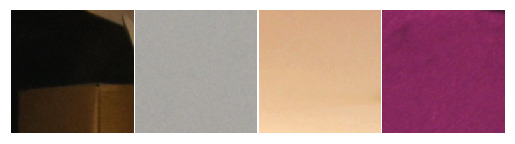


Batch 20/80, generator loss 5.042320728302002, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 2.836676836013794, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 4.546171188354492, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 4.585738658905029, discriminator loss 1.4023796319961548
#33: training loss value = 3.8200249850749968 validation loss value = 3.690005350112915
upscale lr: 0.001, discriminator lr: 1e-05

Batch 20/80, generator loss 4.166018009185791, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 3.355989456176758, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 5.475636959075928, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 3.9995012283325195, discriminator loss 1.4023796319961548
#34: training loss value = 3.804293397068977 validation loss value = 3.660300779342651
upscale lr: 0.001, discriminator lr: 1e-05

Batch 20/80, generator loss 3.625408411026001, discrimi

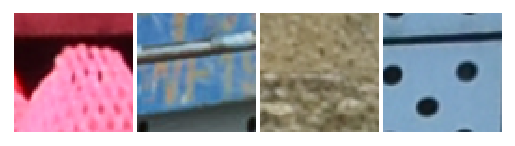

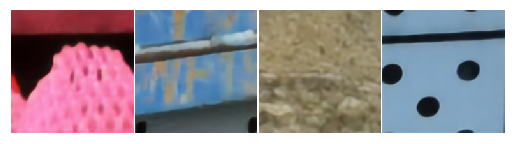

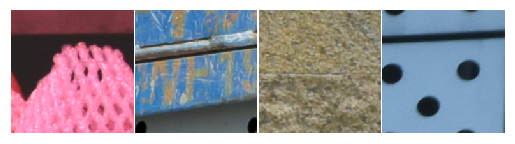


Batch 20/80, generator loss 4.13195276260376, discriminator loss 1.4023796319961548
Batch 40/80, generator loss 2.60668683052063, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 3.8638863563537598, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 3.2168753147125244, discriminator loss 1.4023796319961548
#37: training loss value = 3.7707819163799288 validation loss value = 3.720213568210602
upscale lr: 0.001, discriminator lr: 1e-05

Batch 20/80, generator loss 4.441995143890381, discriminator loss 1.3786367177963257
Batch 40/80, generator loss 4.009222507476807, discriminator loss 1.4023796319961548
Batch 60/80, generator loss 3.291590452194214, discriminator loss 1.4023796319961548
Batch 80/80, generator loss 2.3345284461975098, discriminator loss 1.4023796319961548
#38: training loss value = 3.7600079119205474 validation loss value = 3.6738991498947144
upscale lr: 0.001, discriminator lr: 1e-05

Batch 20/80, generator loss 3.2005908489227295, discr

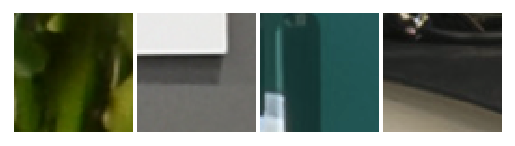

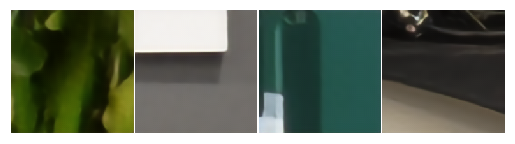

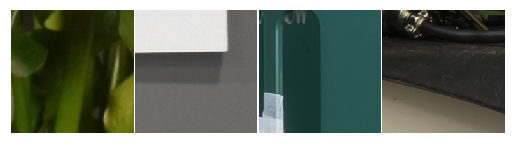

In [3]:
batch_size = 16
N = 64
B = 10
N_discrim = 12

train_dl, val_dl, test_dl = get_train_val_test_dataloaders(batch_size)

discriminator_model = DiscriminatorModel(3, N_discrim, 0.3)
upscaling_model = UpscalingModel(3, 3, 3, N, B)

iters, train_losses, val_losses, discrim_train_losses, discrim_val_losses = \
    train_prototype(upscaling_model, discriminator_model, train_dl, val_dl, num_epochs=500)

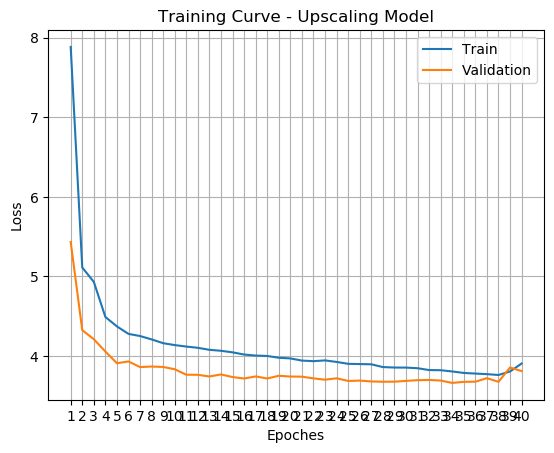

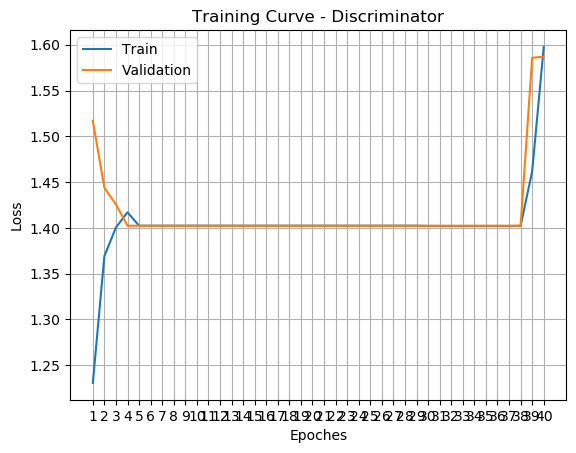

In [4]:
plt.figure()
plt.title("Training Curve - Upscaling Model")
plt.plot(iters, train_losses, label="Train")
plt.plot(iters, val_losses, label="Validation")
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.xticks(range(iters[0], iters[-1]+1))
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.title("Training Curve - Discriminator")
plt.plot(iters, discrim_train_losses, label="Train")
plt.plot(iters, discrim_val_losses, label="Validation")
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.xticks(range(iters[0], iters[-1]+1))
plt.legend()
plt.grid()
plt.show()

In [5]:
#For Testing The Model

def test_prototype_model(test_dl, upscale_model, discriminator_model, criterion):
    device = next(upscale_model.parameters()).device
    
    upscale_model.eval()
    discriminator_model.eval()
    
    test_loss = 0.0
    num_batches = len(test_dl)
    
    with torch.no_grad():
        for inputs_lr, targets_hr in test_dl:
            inputs_lr = inputs_lr.to(device)
            targets_hr = targets_hr.to(device)
            
            generated_hr = upscale_model(inputs_lr)
            generated_outputs = discriminator_model(generated_hr)
            
            loss = criterion(generated_hr, targets_hr, generated_outputs)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / num_batches
    print(f"Average Test Loss: {avg_test_loss}")


In [6]:
#Running the Test Function:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dl, val_dl, test_dl = get_train_val_test_dataloaders(8)

best_val = iters[2:][np.argmin(val_losses[2:])]
print("Best validation loss: epoch", best_val)
print()

discriminator_model = torch.load(f"final_models/model_{best_val}_d.pth").to(device)
upscaling_model = torch.load(f"final_models/model_{best_val}_g.pth").to(device)

print("Testing loss, consistent with training:")
criterion = CombinedLoss(0.5, 1.0, 2.0, 0.0, 1.0, device=device)
test_prototype_model(test_dl,upscaling_model,discriminator_model,criterion)
print()

print("Testing loss, consistent with baseline evaluation:")
criterion = CombinedLoss(0.0, 1.0, 1.0, 1.0, 4.0, device=device)
test_prototype_model(test_dl,upscaling_model,discriminator_model,criterion)
print()


Best validation loss: epoch 34

Testing loss, consistent with training:
Average Test Loss: 4.462434799063439

Testing loss, consistent with baseline evaluation:
Average Test Loss: 5.555372670585034

